In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import string
from nltk.stem import SnowballStemmer
import re
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
stemmer= SnowballStemmer('english')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/aBIR/FinalBalancedDataset.csv')

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
f= open('/content/drive/MyDrive/aBIR/stop_words_english.txt', 'r', encoding='utf-8')
stop_wordsV2= f.readlines()
f.close()

for i in range(len(stop_wordsV2)):
    stop_wordsV2[i]= stop_wordsV2[i].replace('\n', '')
    
for i in range(len(stop_wordsV2)):
    if "'" in stop_wordsV2[i]:
        stop_wordsV2.append(stop_wordsV2[i].replace("'", ''))

stop_wordsV2.append('i')

# Data Visulaization

In [ ]:
data=df.groupby('Toxicity').count()['tweet']
fig = go.Figure([go.Bar(x=data.index.get_level_values(0), y=data.values, text=data.values)])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', title='Distribution of data classes',
                 xaxis_title='Classes (0=Non-Toxic, 1=Toxic)', yaxis_title='Count')
fig.show()

In [ ]:
words= df[df['Toxicity']==1]['tweet'].apply(lambda x : [w for w in re.sub(' +', " ", re.sub("@[0-9a-zA-Z]+|#|https?://[0-9a-zA-Z\./\-_\?]+|â¦|(amp)|[0-9]+", "", x)).translate(str.maketrans('', '', string.punctuation)).strip().split() if not w.lower() in stop_wordsV2])
word={'words':[]}
for group in words:
    for d in group:
        word['words'].append(stemmer.stem(d))

In [ ]:
data=pd.DataFrame(word).value_counts()[:10]
fig = go.Figure([go.Bar(x=data.index.get_level_values(0), y=data.values, text=data.values)])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', title='Top 10 words in toxic tweets',
                 xaxis_title='Words', yaxis_title='Count')
fig.show()

In [ ]:
words= df[df['Toxicity']==0]['tweet'].apply(lambda x : [w for w in re.sub(' +', " ", re.sub("@[0-9a-zA-Z]+|#|https?://[0-9a-zA-Z\./\-_\?]+|â¦|(amp)|[0-9]+", "", x)).translate(str.maketrans('', '', string.punctuation)).strip().split() if not w.lower() in stop_wordsV2])
word={'words':[]}
for group in words:
    for d in group:
        word['words'].append(stemmer.stem(d))

In [ ]:
data=pd.DataFrame(word).value_counts()[:10]
fig = go.Figure([go.Bar(x=data.index.get_level_values(0), y=data.values, text=data.values)])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', title='Top 10 words in non-toxic tweets',
                 xaxis_title='Words', yaxis_title='Count')
fig.show()

In [ ]:
words= df[df['Toxicity']==1]['tweet'].apply(lambda x : re.findall('#[a-zA-Z_0-9]+', x))
word={'words':[]}
for group in words:
    for d in group:
        if len(re.findall('#[0-9]+',d)) == 0:#filter hashtags which are all numbers (e.g. #198473)
            word['words'].append(d)
data=pd.DataFrame(word).value_counts()[:10]
fig = go.Figure([go.Bar(x=data.index.get_level_values(0), y=data.values, text=data.values)])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', title='Top 10 toxic hashtags',
                 xaxis_title='Hashtag', yaxis_title='Number of apperence')
fig.show()

In [ ]:
words= df[df['Toxicity']==0]['tweet'].apply(lambda x : re.findall('#[a-zA-Z_0-9]+', x))
word={'words':[]}
for group in words:
    for d in group:
        if len(re.findall('#[0-9]+',d)) == 0:#filter hashtags which are all numbers (e.g. #198473)
            word['words'].append(d)
data=pd.DataFrame(word).value_counts()[:10]
fig = go.Figure([go.Bar(x=data.index.get_level_values(0), y=data.values, text=data.values)])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', title='Top 10 non-toxic hashtags',
                 xaxis_title='Hashtag', yaxis_title='Number of apperence')
fig.show()

In [ ]:
import numpy as np

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

# Prepare data for ML Classifier

In [ ]:
#Clean text of meaningless words
def clean_words(x):
    a= [w for w in re.sub(' +', " ", re.sub(r"#[0-9]+|@[0-9a-zA-Z]+|#|https?://[0-9a-zA-Z\./\-_\?]+|â¦|(amp)|[^\x20-\x7e]|â|¥|ð|»|¼|ï|¸|¦|±|¯|[0-9]+", "", x)).translate(str.maketrans('', '', string.punctuation)).strip().split() if not w.lower() in stop_wordsV2]
    return " ".join([stemmer.stem(i) for i in a])
    
df['Cleaned_tweets']= df['tweet'].apply(lambda x : clean_words(x))

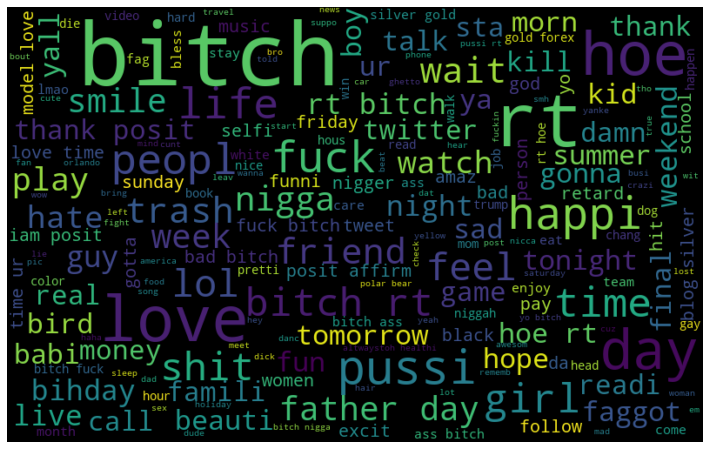

In [ ]:
all_words = " ".join([sentence for sentence in df['Cleaned_tweets']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

## plot then graph

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Split data
from sklearn.model_selection import train_test_split
x=df['Cleaned_tweets']
y=df['Toxicity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# ML Pipeline

In [ ]:

pipeline1= Pipeline([
    ('count', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', SVC(kernel='linear',probability=True, random_state=0))
])

In [ ]:
pipeline1.fit(x_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tf', TfidfTransformer()),
                ('clf',
                 SVC(kernel='linear', probability=True, random_state=0))])

In [ ]:
from sklearn.metrics import roc_curve

pred= pipeline1.predict(x_test)
pred2 = pipeline1.predict_proba(x_test)

# roc curve 
fpr1, tpr1, thresh1 = roc_curve(y_test, pred2[:,1], pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9720
           1       0.96      0.91      0.93      7304

    accuracy                           0.94     17024
   macro avg       0.95      0.94      0.94     17024
weighted avg       0.94      0.94      0.94     17024



In [ ]:
print(confusion_matrix(y_test, pred))

[[9418  302]
 [ 646 6658]]


In [ ]:
d = np.array(y_test) - np.array(pred)
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MAE: 0.05568609022556391
MSE: 0.05568609022556391
RMSE: 0.23597900378119216
R-Squared: 0.9316633248753425


In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
pipeline2= Pipeline([
    ('count', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', KNeighborsClassifier())
])

In [ ]:
pipeline2.fit(x_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

In [ ]:
pred= pipeline2.predict(x_test)
pred2 = pipeline2.predict_proba(x_test)

# roc curve 
fpr2, tpr2, thresh2 = roc_curve(y_test, pred2[:,1], pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.67      0.96      0.79      9720
           1       0.88      0.36      0.51      7304

    accuracy                           0.71     17024
   macro avg       0.78      0.66      0.65     17024
weighted avg       0.76      0.71      0.67     17024



In [ ]:
d = np.array(y_test) - np.array(pred)
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MAE: 0.29458411654135336
MSE: 0.29458411654135336
RMSE: 0.5427560377751254
R-Squared: 0.6384932217825345


In [ ]:
pipeline3= Pipeline([
    ('count', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())
])

In [ ]:
pipeline3.fit(x_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

In [ ]:
pred= pipeline3.predict(x_test)
pred2 = pipeline3.predict_proba(x_test)

# roc curve 
fpr3, tpr3, thresh3 = roc_curve(y_test, pred2[:,1], pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      9720
           1       0.92      0.91      0.92      7304

    accuracy                           0.93     17024
   macro avg       0.93      0.93      0.93     17024
weighted avg       0.93      0.93      0.93     17024



In [ ]:
print(confusion_matrix(y_test, pred))

[[9133  587]
 [ 642 6662]]


In [ ]:
d = np.array(y_test) - np.array(pred)
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MAE: 0.0721921992481203
MSE: 0.0721921992481203
RMSE: 0.2686860607625939
R-Squared: 0.9114074116791097


In [ ]:
pipeline4= Pipeline([
    ('count', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

In [ ]:
pipeline4.fit(x_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [ ]:
pred= pipeline4.predict(x_test)
pred2 = pipeline4.predict_proba(x_test)

# roc curve 
fpr4, tpr4, thresh4 = roc_curve(y_test, pred2[:,1], pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      9720
           1       0.94      0.92      0.93      7304

    accuracy                           0.94     17024
   macro avg       0.94      0.94      0.94     17024
weighted avg       0.94      0.94      0.94     17024



In [ ]:
print(confusion_matrix(y_test, pred))

[[9264  456]
 [ 570 6734]]


In [ ]:
d = np.array(y_test) - np.array(pred)
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MAE: 0.060267857142857144
MSE: 0.060267857142857144
RMSE: 0.24549512651549144
R-Squared: 0.9260406870486302


In [ ]:
pipeline5= Pipeline([
    ('count', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', AdaBoostClassifier())
])

In [ ]:
pipeline5.fit(x_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tf', TfidfTransformer()),
                ('clf', AdaBoostClassifier())])

In [ ]:
pred= pipeline5.predict(x_test)
pred2 = pipeline5.predict_proba(x_test)

# roc curve 
fpr5, tpr5, thresh5 = roc_curve(y_test, pred2[:,1], pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      9720
           1       0.94      0.86      0.90      7304

    accuracy                           0.92     17024
   macro avg       0.92      0.91      0.91     17024
weighted avg       0.92      0.92      0.92     17024



In [ ]:
print(confusion_matrix(y_test, pred))

[[9349  371]
 [1051 6253]]


In [ ]:
d = np.array(y_test) - np.array(pred)
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MAE: 0.08352913533834587
MSE: 0.08352913533834587
RMSE: 0.28901407463711154
R-Squared: 0.8974949873130138


In [ ]:
pipeline6= Pipeline([
    ('count', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [ ]:
pipeline6.fit(x_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
pred= pipeline6.predict(x_test)
pred2 = pipeline6.predict_proba(x_test)

# roc curve 
fpr6, tpr6, thresh6 = roc_curve(y_test, pred2[:,1], pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      9720
           1       0.88      0.91      0.90      7304

    accuracy                           0.91     17024
   macro avg       0.91      0.91      0.91     17024
weighted avg       0.91      0.91      0.91     17024



In [ ]:
print(confusion_matrix(y_test, pred))

[[8823  897]
 [ 635 6669]]


In [ ]:
d = np.array(y_test) - np.array(pred)
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MAE: 0.0899906015037594
MSE: 0.0899906015037594
RMSE: 0.29998433543063446
R-Squared: 0.8895656262753425


In [ ]:
pipeline7= Pipeline([
    ('count', CountVectorizer()),
    ('tf', TfidfTransformer()),
    ('clf', LogisticRegression())
])


In [ ]:
pipeline7.fit(x_train, y_train)

Pipeline(steps=[('count', CountVectorizer()), ('tf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [ ]:
pred= pipeline7.predict(x_test)
pred2 = pipeline7.predict_proba(x_test)

# roc curve 
fpr7, tpr7, thresh7 = roc_curve(y_test, pred2[:,1], pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9720
           1       0.96      0.88      0.92      7304

    accuracy                           0.94     17024
   macro avg       0.94      0.93      0.93     17024
weighted avg       0.94      0.94      0.94     17024



In [ ]:
print(confusion_matrix(y_test, pred))

[[9475  245]
 [ 851 6453]]


In [ ]:
d = np.array(y_test) - np.array(pred)
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))
rmse_f = np.sqrt(mse_f)
r2_f = 1-(sum(d**2)/sum((y-np.mean(y))**2))

print("MAE:",mae_f)
print("MSE:", mse_f)
print("RMSE:", rmse_f)
print("R-Squared:", r2_f)

MAE: 0.0643796992481203
MSE: 0.0643796992481203
RMSE: 0.2537315495718266
R-Squared: 0.9209947300246576


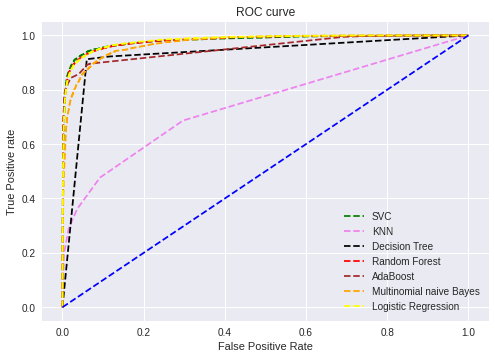

In [ ]:
#  ROC curve 


random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves

plt.plot(fpr1, tpr1, linestyle='--',color='green', label='SVC')
plt.plot(fpr2, tpr2, linestyle='--',color='violet', label='KNN')
plt.plot(fpr3, tpr3, linestyle='--',color='black', label='Decision Tree')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='Random Forest')
plt.plot(fpr5, tpr5, linestyle='--',color='brown', label='AdaBoost')
plt.plot(fpr6, tpr6, linestyle='--',color='orange', label='Multinomial naive Bayes')
plt.plot(fpr7, tpr7, linestyle='--',color='yellow', label='Logistic Regression')



plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();